![Diagramme of  InPoDA IN304.drawio.png](<attachment:Diagramme of  InPoDA IN304.drawio.png>)
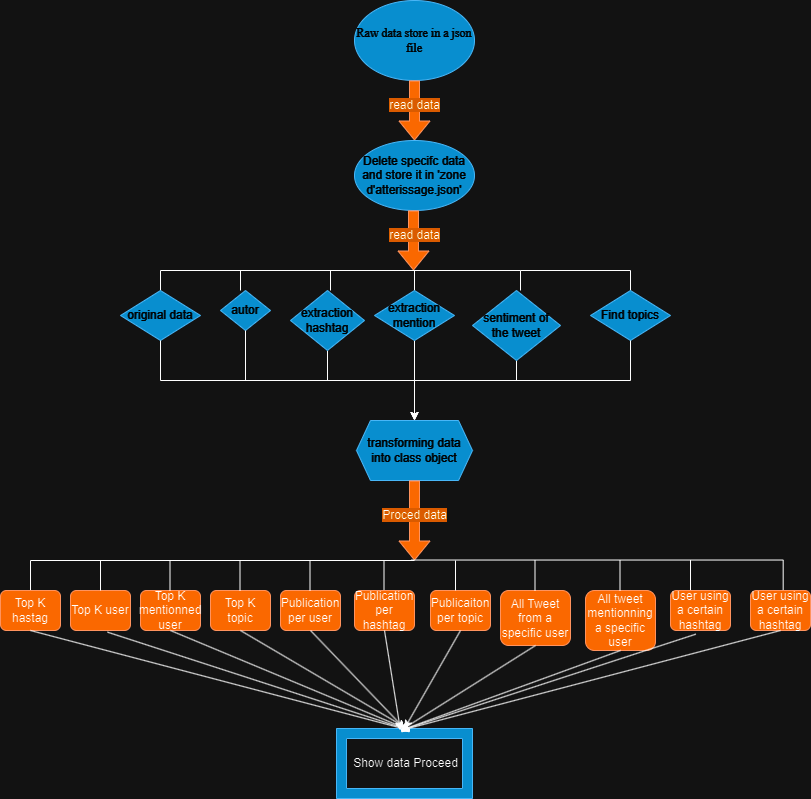

# Library to execute the program

In [1]:
# Regular expressions for text processing
from re import sub, findall, compile, escape
from collections import Counter
# create author name
from random import randint
# Sentiment analysis library
from textblob import TextBlob
# Libraries for topic modeling
from gensim import corpora, models
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# Working with JSON data
from json import loads, dump
# visualize data
from matplotlib.pyplot import figure, bar, xlabel, ylabel, title, show
from matplotlib.pyplot import barh, gca, subplots, subplots_adjust
from matplotlib.ticker import MaxNLocator
from datetime import datetime

# Delete specific caracter, read and write data.

In [2]:
def tweet_analyze(tweet_txt):
    '''
    Analyze and modify a sentence by removing specific characters, preserving
    alphanumeric characters, spaces, and essential punctuation.

    Args:
        - tweet_txt (str): The input sentence to analyze and correct.

    Returns:
        - str: The modified sentence with specific characters removed.
          If tweet_txt is not a string, it returns itself.

    This function removes characters that are not part of the alphabet (both
    uppercase and lowercase), numbers (0-9), spaces, newlines, and essential
    punctuation marks, including @, #, (), {}, [], <>, «», &, -, _, +, *, /,
    %, ', °, :, €, £, $, ., ,, ;, !, and ?.
    '''
    # test if tweet_txt is a str
    if isinstance(tweet_txt, str):
        # delete caracter that aren't in the pattern with sub
        return sub(r"[^A-Za-z0-9\s@#(){}[\]<>«»&\-_+*/%'°:€£$&.,;!?]", '', tweet_txt)
    # not a string so we doesn't modify it
    return tweet_txt


def checking_structure(Tweet):
    '''
    Check if all the expected keys are present in a dictionary.

    Args:
        - Tweet (dict): A dictionary representing a tweet data.

    Returns:
        bool: True if all expected keys are found in the dictionary, False otherwise.
    '''
    # List of expected keys
    expected_keys = ["id", "AuthorLocation", "CreatedAt", "RetweetCount", "TweetLanguage", "TweetText"]            
    # Get the set of keys in the Tweet
    keys_in_tweet = set(Tweet.keys())
    # Check if all expected keys are a subset of the keys in the Tweet
    return set(expected_keys).issubset(keys_in_tweet)
    


def process_json_file(storage_file="zone d’atterrissage.json", file_to_read="aitweets.json", structure_check=True):
    '''
    Process a JSON file containing tweet data, cleaning and storing the data in a new file.

    Args:
        - storage_file (str): The name of the file where processed data will be stored.
          It is created or truncated if it already exists.
        - file_to_read (str): The name of the JSON file containing tweet data to be processed.
        - structure_check (bool): If True, checks if the tweet data follows a specific structure.
          If False, no structure checks are performed have to get a function named chechking_struture
          to work.

    Returns:
        None

    This function reads the specified JSON file, processes each line, and writes the processed
    data to a new file. The processed data includes cleaned tweet contents.
    The function can also perform a structure check to ensure that the tweet data includes
    specific keys as defined in the "Structure_tweet" list. If any tweet doesn't match the
    expected structure and structure_check is set to True, that tweet is skipped.
    This function will add a random user name if the dictionnary doesn't have one name are : userx 
    x is an integer from 0 to 99
    '''
    # Generate a list of user names from "user0" to "user99"
    user_list = ["user" + str(x) for x in range(100)]
    size = len(user_list) - 1

    # Open the storage file to create or truncate it
    with open(storage_file, "w", encoding='utf-8'):
        pass

    # Read lines from the source file
    lines = read_file(file_to_read)

    # Open the storage file for writing
    with open(storage_file, "a", encoding="utf-8") as json_file:
        for line_num, line in enumerate(lines):
            Tweet = loads(line)

            # Perform structure check if required
            if structure_check and not checking_structure(Tweet):
                continue  # Skip this tweet if the structure check fails
            if "Author" not in Tweet:
                Tweet["Author"] = user_list[randint(0, size)]
            for key in Tweet:
                Tweet[key] = tweet_analyze(Tweet[key])

            # write the data
            dump(Tweet, json_file, ensure_ascii=False)

            # provide a new blanc line at the end of the file
            if line_num < len(lines) - 1:
                json_file.write('\n')


def read_file(file_name="zone d’atterrissage.json"):
    '''
    Read the file named "zone d’atterrissage.json" and return its lines.

    This function reads the contents of the specified file and returns a list of lines.

    Args:
        - file_name (str): The name of the file to read. Default is "zone d’atterrissage.json".

    Returns:
        - list: A list of lines from the file    
    '''
    # encoding="utf-8" because of some caracter it can crash
    with open(file_name, "r", encoding="utf-8") as file:      
        return file.readlines()

# Find information of a tweet.

In [3]:
def autor_finder(tweet_dict):
    '''
    Take a dictionnary and find the id (autor)

    Arg :
       - tweet_dict (dict): a dictionnary that must have a "id" componant

    return :
      - the value of the "id" key if it exists, or None if the key is not found
    '''
    if "id" in tweet_dict:
        return tweet_dict["id"]
    return None


def extraction_target_character(tweet_txt, target_character):
    '''
    Extract words following a target character in a sentence.

    Args:
     - tweet_txt (str): The input sentence to search for the target character.
     - target_character (str): The character to search for in a regex pattern.

    Returns:
        - dict: A dictionary where keys are the words following the specified
          target_character, and values are their respective counts.
        - An empty dictionary is returned if no matching characters are found.
    '''
    # create a re pattern
    target_pattern = compile(escape(target_character) + r'\w+')
    # create a list of substrings in the sentence that match the given pattern.
    target_matches = findall(target_pattern, tweet_txt)
    # if it containt things than it return his content
    if target_matches:
        # Use Counter to count occurrences of target matches.
        target_counts = Counter(target_matches)
        return dict(target_counts)
    return {}


def feelings_text(tweet_txt):
    '''
    Analyze the sentiment of a sentence and return
    the sentiment as a string.

    Arg :
        - tweet_txt (str): The input sentence to analyze for sentiment.

    Return :
        - str: A string representing the sentiment,
        which can be 'Positive,' 'Negative,' or 'Neutral.'
    '''
    # create a blob chat box
    blob = TextBlob(tweet_txt)
    # using blob to calculate sentiment
    feelings = blob.sentiment.polarity
    if feelings > 0:
        return "Positive"
    elif feelings < 0:
        return "Negative"
    else:
        return "Neutral"
    

def tweet_topics_finder(tweet_txt, num_topics=3):
    '''
    I took part of code on stackoverflow
    Args:
        - tweet_txt (str): The input tweet text to be analyzed.
        - num_topics (int, optional): The number of topics to consider.
        Default is 3.

    Returns:
        - list: A list of words representing the dominant topic in the
        input tweet.
    '''
    # - Tokenization and stop word removal
    # - stop words of a language example for eng : , . ! ect
    stop_words = set(stopwords.words('french'))
    # break the txt into word/tokens
    words = word_tokenize(tweet_txt)
    # - word.lower() -> word to lowercase better analise
    # - word.isalpha() -> checks if the word consists only of alphabetic
    words = [word for word in words if word.lower()
             not in stop_words and word.isalpha()]

    # - Create a dictionary and a corpus
    # - corpora.Dictionary() in Gensim creates a dictionary that connects each
    # word in a cleaned list of words to a unique number. This mapping of
    # words to unique IDs is crucial for various text analysis tasks like
    # topic modeling. It allows you to work with words more efficiently in
    # text analysis, as you can refer to them by their unique IDs.
    dictionary = corpora.Dictionary([words])

    # - dictionary.doc2bow(words) is converting a list of words into a bag of
    # words format, and it counts how many times each word appears
    # in the list words.
    corpus = [dictionary.doc2bow(words)]

    # - Perform LDA
    # - id2word=dictionary:specifying the mapping between word IDs and
    # actual words in the dictionary created earlier
    lda_model = models.LdaModel(corpus, num_topics=num_topics,
                                id2word=dictionary)

    # - Assign topics to the tweet
    # - applaying lda model to our corpus to get topics
    topics = lda_model[corpus[0]]
    # - identifies the topic with the highest weight
    # - [0] extracts the first element of the tuple that max returns.
    # This element is the index of the dominant topic in the topics list
    dominant_topic = max(topics, key=lambda x: x[1])[0]

    # - Sort the top words by weight
    # - lda_model.show_topic(dominant_topic) retrieves the list of words and
    # their corresponding weights that are associated with the dominant topic.
    # key=lambda x: x[1] sorts this list based on the second element of each
    # item in the list,which represents the weight of the word within the topic
    top_words = sorted(lda_model.show_topic(dominant_topic),
                       key=lambda x: x[1], reverse=True)

    # Extract the words
    # slice to select first dominant topic
    # word, _ to hold componant _ bcs we don't want the weight
    tweet_topic = [word for word, _ in top_words[:dominant_topic]]
    return tweet_topic

# Reading "zone d'atterissage.json" and transforme data into object

In [4]:
class TweetObjectCreator:
    '''
    A class to represent a tweet object.

        - Attributes:
        - Author (str): author of the tweet.
        - id (str): id of the tweet.
        - AuthorLocation (str): The author's location.
        - CreatedAt (str): The timestamp when the tweet was created.
        - RetweetCount (str): The number of retweets.
        - TweetLanguage (str): The language of the tweet.
        - TweetText (str): The text of the tweet.
        - HashtagDict (dict): List of hashtags in the tweet.
        - MentionedUser (list): List of mentioned users in the tweet.
        - Sentiment (str): The sentiment of the tweet (Positive, Negative,
        or Neutral).
        - Topics (list): List of topics associated with the tweet.

        Methods:
            - extract_caracter(self, caracter): Extract caracter (@ or #)
            from the tweet text.
            - Feelings(self): Analyze the sentiment of the tweet.
            - Topics_(self): Extract topics from the tweet text.

        Args:
            - tweet_zone_atterrissage (dict): A dictionary representing
            the tweet data.
    '''
    def extract_caracter(self, caracter):
        '''
        Extract the "caracter" from the tweet text.
        Using a function : extraction_target_character(self.TweetText,
        caracter) this have to be coded or import

        Arg :
            - caracter (str): a caracter to search in the txt

        Returns:
            - list: A list of word that follow the "caracter"
            - found in the tweet text.
        '''
        return extraction_target_character(self.TweetText, caracter)

    def Feelings(self):
        '''
        Analyze the sentiment of the tweet.
        Using a function : feelings_text(self.TweetText)
        this have to be coded or import

        Returns:
            str: The sentiment of the tweet ('Positive',
            'Negative', or 'Neutral').
        '''
        return feelings_text(self.TweetText)

    def Topics_(self):
        '''
        Extract topics from the tweet text.
        Using a function : tweet_topics_finder(self.TweetText)
        this have to be coded or import

        Returns:
            list: A list of topics associated with the tweet.
        '''
        return tweet_topics_finder(self.TweetText)

    def __init__(self, tweet_zone_atterissage):
        '''
        Initialize a Tweet object.

            Args:
                -tweet_zone_atterrissage (dict):
            - A dictionary representing the tweet data.
            - This dictionary should contain : keys like 'id',
            'AuthorLocation', 'CreatedAt', 'RetweetCount',
            'TweetLanguage', and 'TweetText'.
        '''
        self.Author = tweet_zone_atterissage.get("Author", "")
        self.id = tweet_zone_atterissage.get("id", "")
        self.AuthorLocation = tweet_zone_atterissage.get("AuthorLocation", "")
        self.CreatedAt = tweet_zone_atterissage.get("CreatedAt", "")
        self.RetweetCount = tweet_zone_atterissage.get("RetweetCount", "")
        self.TweetLanguage = tweet_zone_atterissage.get("TweetLanguage", "")
        self.TweetText = tweet_zone_atterissage.get("TweetText", "")
        self.HashtagDict = self.extract_caracter("#")
        self.MentionnedUser = self.extract_caracter("@")
        self.Sentiment = self.Feelings()
        self.Topics = self.Topics_()


def transformation_object(file_lines):
    '''
    Transform a list of JSON-encoded tweet lines into a list of Tweet objects.

    This function takes a list of lines, each containing a JSON-encoded tweet,
    and transforms them into a list of Tweet objects using the `TweetObjectCreator`.
    This function have to get a class creator named TweetObjectCreator to work.
    Args:
        - file_lines (list): A list of lines, each representing a JSON-encoded tweet.

    Returns:
        - list: A list of Tweet objects created from the JSON-encoded tweets.
    '''
    tweet_list = []
    for line in file_lines:
        tweet_list.append(TweetObjectCreator(loads(line)))
    return tweet_list

# Analyze data

In [5]:
def top_k(tweetlist, k, search_type="hashtag", ReTweet=True):
    '''
    Get the top K elements based on a search type.
    this function is using 4 external function to work.
    hastag_dict, user_dict, mentionned_dict, topic_dict

    Args:
        - tweetlist (list): List of Tweet objects.
        - k (int): Number of top elements to retrieve.
        - search_type (str): The type of search: 'hashtag', 'user',
        'mentionned', or 'topic'.
        - ReTweet (bool): Include retweet counts when calculating top K.

    Returns:
        - dict: A dictionary containing the top (max) K elements.
    '''
    if search_type == "hashtag":
        dict_k = hastag_dict(tweetlist, ReTweet)
    elif search_type == "user":
        dict_k = user_dict(tweetlist, ReTweet)
    elif search_type == "mentionned":
        dict_k = mentionned_dict(tweetlist, ReTweet)
    elif search_type == "topic":
        dict_k = topic_dict(tweetlist, ReTweet)
    else:
        # or flake8 says the line too long
        raise ValueError("Invalid search_type. Use 'hashtag', 'user', 'mentionned' or 'topic'.")
    # make a dict by comprehension with is sorted by his value and not key
    # dict_k.items() -> returns a list of key-value pairs from the dict_k
    # The key parameter is set to lambda item: item[1]. This means that for
    # each key-value pair (item) in the list, the sorting function uses the
    # value (item[1]) to determine the sort order.
    # reverse=True is used to sort in descending order
    # comma : to separate the key and value placeholders
    sorted_dict_k = {key: value for key, value in
                     sorted(dict_k.items(),
                            key=lambda item: item[1], reverse=True)}
    if k >= len(sorted_dict_k):
        return sorted_dict_k
    else:
        # for k in list(sorted_dict_k)[:k] iterates through the keys
        # of the sorted_dict_k
        return {k: sorted_dict_k[k] for k in list(sorted_dict_k)[:k]}
    

def hastag_dict(tweetlist, ReTweet):
    '''
    Get the count of hashtags based on the provided Tweet list.

    Args:
        - tweetlist (list): List of Tweet objects.
        - ReTweet (bool): Include retweet counts when calculating.

    Returns:
        - dict: A dictionary containing hashtags count.
    '''
    dict_ = {}
    for tweet in tweetlist:
        # tweet.HashtagDict -> dict
        for hashtag in tweet.HashtagDict:
            if hashtag in dict_:
                dict_[hashtag] += tweet.HashtagDict[hashtag]
            else:
                dict_[hashtag] = tweet.HashtagDict[hashtag]
            if ReTweet:
                # tweet.RetweetCount -> str
                dict_[hashtag] += int(tweet.RetweetCount)
    return dict_



def user_dict(tweetlist, ReTweet):
    '''
    Get the count of users based on the provided Tweet list.

    Args:
        - tweetlist (list): List of Tweet objects.
        - ReTweet (bool): Include retweet counts when calculating.

    Returns:
        - dict: A dictionary containing users count.
    '''
    dict_ = {}
    for tweet in tweetlist:
        # to not look for the value multiple time
        # tweet.Author -> str
        user_id = tweet.Author
        if user_id in dict_:
            dict_[user_id] += 1
        else:
            dict_[user_id] = 1
        if ReTweet:
            # tweet.RetweetCount -> str
            dict_[user_id] += int(tweet.RetweetCount)
    return dict_



def mentionned_dict(tweetlist, ReTweet):
    '''
    Get the top K mentioned users based on the provided Tweet list.

    Args:
        - tweetlist (list): List of Tweet objects.
        - ReTweet (bool): Include retweet counts when calculating.

    Returns:
        - dict: A dictionary containing mentioned users counted.
    '''
    dict_ = {}
    for tweet in tweetlist:
        # tweet.MentionnedUser -> dict
        for mention in tweet.MentionnedUser:
            if mention in dict_:
                dict_[mention] += tweet.MentionnedUser[mention]
            else:
                dict_[mention] = tweet.MentionnedUser[mention]
            if ReTweet:
                # tweet.RetweetCount -> str
                dict_[mention] += int(tweet.RetweetCount)
    return dict_



def topic_dict(tweetlist, ReTweet):
    '''
    Get the count of topics based on the provided Tweet list.

    Args:
        - tweetlist (list): List of Tweet objects.
        - ReTweet (bool): Include retweet counts when calculating.

    Returns:
        - dict: A dictionary containing the topics count.
    '''
    dict_ = {}
    for tweet in tweetlist:
        # tweet.Topics -> list
        for topic in tweet.Topics:
            if topic in dict_:
                dict_[topic] += 1
            else:
                dict_[topic] = 1
            if ReTweet:
                # tweet.RetweetCount -> str
                dict_[topic] += int(tweet.RetweetCount)
    return dict_


def get_tweets(tweet_list, user, search_type='user'):
    '''
    Retrieves tweets authored by a specific user or mentions of a user
    within a list of tweets.

    Args:
        - tweet_list (list): List of Tweet objects.
        - user (str): The user or author to filter by.
        - search_type (str): Specify "user" to retrieve tweets by an author
        or "mention" to retrieve mentions.

    Returns:
        - list: A list of tweets (dict) authored by the specified user or
        containing mentions. For 'user' search_type, the dictionary contains
        the tweet text as keys and their corresponding creation date as values.
        For 'mention' search_type, it returns a list of dictionaries containing
        details (as dictionaries) of tweets mentioning the specified user.

    Raises:
        - ValueError: If an invalid search_type is provided. Use 'user' or
        'mention'.
    '''
    if search_type == "user":
        dict_user = {}
        for tweet in tweet_list:
            if user == tweet.Author:
                dict_user[tweet.TweetText] = tweet.CreatedAt[:10]
        return dict_user
    # [vars(tweet) for tweet in tweet_list if tweet.Author == user]
    elif search_type == "mention":
        dict_mention = {}
        for tweet in tweet_list:
            if user in tweet.MentionnedUser:
                dict_mention[tweet.TweetText] = tweet.CreatedAt[:10]
        return dict_mention
    else:
        raise ValueError("Invalid search_type. Use 'userid' or 'mention'.")
    

def get_users(tweet_list, term, search_type="hashtag"):
    """
    Retrieve users based on a specific search type within a tweet list.

    Args:
    - tweet_list (list): A list of tweet objects to search through.
    - term (str): The search term, either a hashtag or a mentioned user's name.
    - search_type (str, optional): Specifies the type of search to perform.
    Defaults to 'hashtag'.
      Choose between 'hashtag' to find users mentioning a specific hashtag,
      or 'mention' to find users being mentioned in tweets.

    Returns:
    - dict: A dictionary containing user names as keys and their respective
    occurrence counts based on the search criteria provided.

    Raises:
    - ValueError: If an invalid search_type is provided. Use 'hashtag'
    or 'mention'.
    """
    if search_type == "hashtag":
        dict_hastag = {}
        for tweet in tweet_list:
            if term in tweet.HashtagDict:
                if tweet.Author in dict_hastag:
                    dict_hastag[tweet.Author] += 1
                else:
                    dict_hastag[tweet.Author] = 1
        return dict_hastag
    elif search_type == "mention":
        # tweet.MentionnedUser -> dict so we need to go through it to get value
        dico_mention = {}
        for tweet in tweet_list:
            if term == tweet.Author:
                for user in tweet.MentionnedUser:
                    if user in dico_mention:
                        dico_mention[user] += 1
                    else:
                        dico_mention[user] = 1
        return dico_mention
    else:
        raise ValueError("Invalid search_type. Use 'hashtag' or 'mention'.")

# Visualyze data

In [6]:
def visualyze_stick_digram(data, axis_x, axis_y, tile_name, size_fig=(8, 8),
                           vertical=True):
    '''
    Using matplotlib.pyplot to show data with graph in a dictionnary

    Args :
        - data (dict) : your data that you want to put into the graph,
        values are int
        - axis_x (str): name of the x axis
        - axis_y (str): name of the y axis
        - title_name (str): tilte of the graph
        - size_fig (tuple): have to be 2 int, based set on (8, 8)
        - data_axis (bool): if true put keys of dict on x axis,
        if faulse put it in y aixs

    Ouput:
        - a matplotlib graph of the data
    '''
    categories = list(data.keys())
    values = list(data.values())

    figure(figsize=size_fig)
    
    xlabel(axis_x)
    ylabel(axis_y)
    title(tile_name)
    # axis data
    if vertical:
        bar(categories, values)
        gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    else:
        barh(categories, values)
        gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    show()


def visualize_timeline(data, axis_x, axis_y, title_name, size_fig=(15, 15)):
    """
    Visualizes tweets over time on a timeline.

    Parameters:
    - data (dict): A dictionary containing tweet dates as keys and
    corresponding texts as values.
    - axis_x (str): Label for the x-axis.
    - axis_y (str): Label for the y-axis (not used in this visualization).
    - title_name (str): Title of the plot.
    - size_fig (tuple, optional): Size of the figure (default is (15, 15)).

    Returns:
    - None (displays the plot).
    """
    # Extract texts and dates from the provided data
    tweets_texts = list(data.keys())
    tweets_dates = list(data.values())

    # Remove newlines from text
    tweets_texts = [text.replace('\n', '') for text in tweets_texts]

    # Convert dates to datetime objects
    tweets_dates = [datetime.strptime(date, '%Y-%m-%d')
                    for date in tweets_dates]

    # Count the number of tweets per day
    tweet_count = {}
    for date in tweets_dates:
        date_str = date.strftime('%Y-%m-%d')
        if date_str in tweet_count:
            tweet_count[date_str] += 1
        else:
            tweet_count[date_str] = 1

    # Create subplots for the timeline and text visualization
    fig, (ax1, ax2) = subplots(1, 2, figsize=size_fig)
    subplots_adjust(wspace=-0.45)
    # To track y positions for each date
    y_positions = {}
    for date, _ in zip(tweets_dates, tweets_texts):
        date_str = date.strftime('%Y-%m-%d')
        count = tweet_count[date_str]
        if date_str in y_positions:
            y_pos = y_positions[date_str]
        else:
            y_pos = 0
            y_positions[date_str] = y_pos

        # Plot tweets on the timeline subplot (ax1)
        ax1.plot_date(date, count - y_pos, markersize=10)
        y_positions[date_str] += 1

    # Format the x-axis of the timeline subplot with dates
    ax1.xaxis_date()
    # Rotate dates for better readability
    fig.autofmt_xdate()

    # Plot the text on the text subplot (ax2)
    for i, (text, date) in enumerate(zip(tweets_texts, tweets_dates)):
        # Adjust the text position
        ax2.text(0.502, 0.95 - i * 0.05, text, va='top', ha='left')
        # Add dots to represent tweets
        ax2.plot(0.5, 0.95 - i * 0.05, marker='o', markersize=8)

    # Hide axis and set labels, title, and limits for the timeline
    # subplot (ax1)
    ax2.axis("off")
    ax1.set_xlabel(axis_x)
    ax1.set_ylabel('Number of Tweets')
    ax1.set_title(title_name)
    ax1.set_ylim(0, max(tweet_count.values()) + 1)  # Set y-axis limits
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.grid()

    # Display the plot
    show()

# Main

Processing data (reading, writing, stock data in object)

In [7]:
process_json_file(storage_file="zone d’atterrissage.json", file_to_read="aitweets.json", structure_check=True)
line = read_file(file_name="zone d’atterrissage.json")
object_list = transformation_object(line)


Diplaying data with stick chart.
visualyze_stick_digram() work only with top_k, user_/hashtag_/topic_dict a,d get_users

In [8]:
top_hashtag= top_k(object_list, 10, search_type='hashtag', ReTweet=False)
top_user = top_k(object_list, 10, search_type='user')
top_mentionned = top_k(object_list, 10, search_type='mentionned')
top_topic = top_k(object_list, 10, search_type='topic')
number_user = user_dict(object_list, ReTweet=False)
number_hashtag = hastag_dict(object_list, ReTweet=False)
number_topic = topic_dict(object_list, ReTweet=False)
user_hashtag = get_users(object_list, "#IA", search_type="hashtag")
user_mention = get_users(object_list, "user46", search_type="mention")


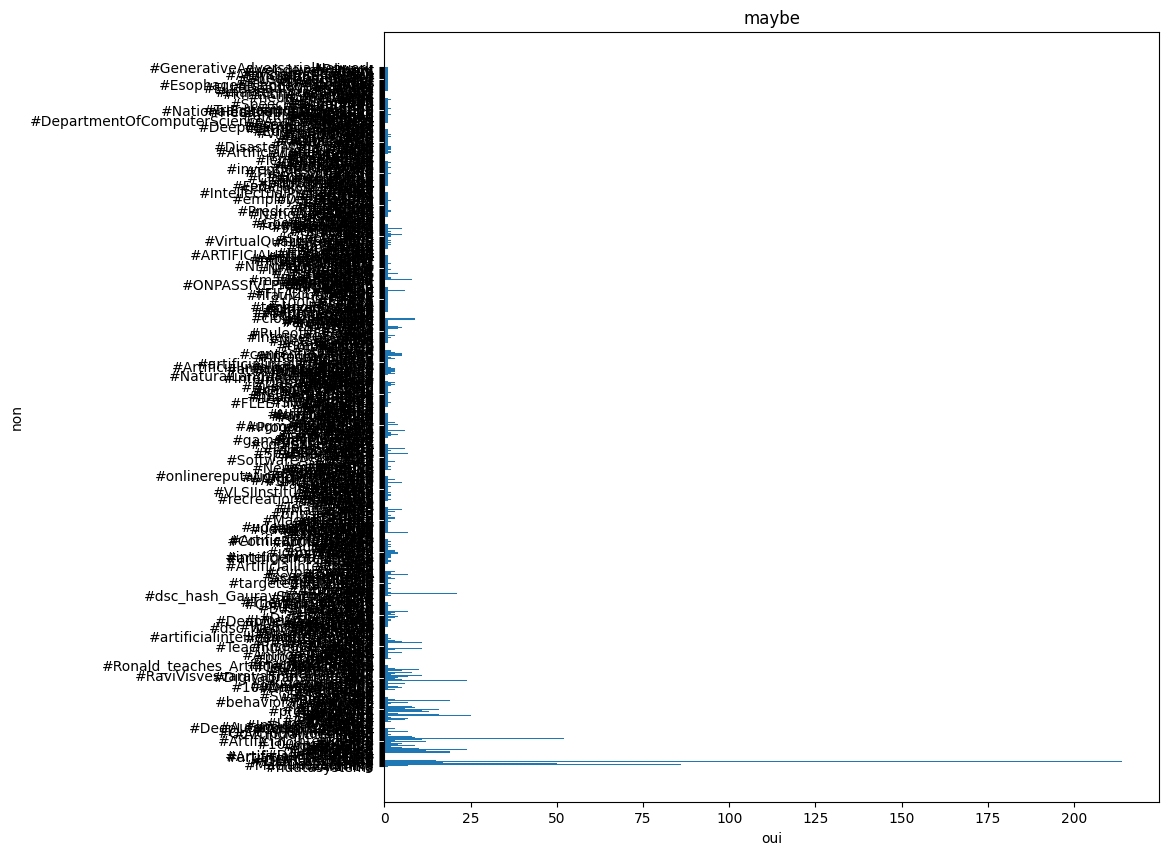

In [9]:
# for user_dict(),hastag_dict(), topic_dict you might want to up y axis of size_fig to 100 if your using aitweets.json
# or it will be unreadable
visualyze_stick_digram(number_hashtag, "oui", "non", "maybe", size_fig=(10, 10), vertical=False)

Displaying tweet txt by data.
Only get_tweets() function work with visualize_timeline

In [10]:
tweet_mention = get_tweets(object_list, "@Datascience__", search_type="mention")
tweet_user = get_tweets(object_list, "user42", search_type="user")

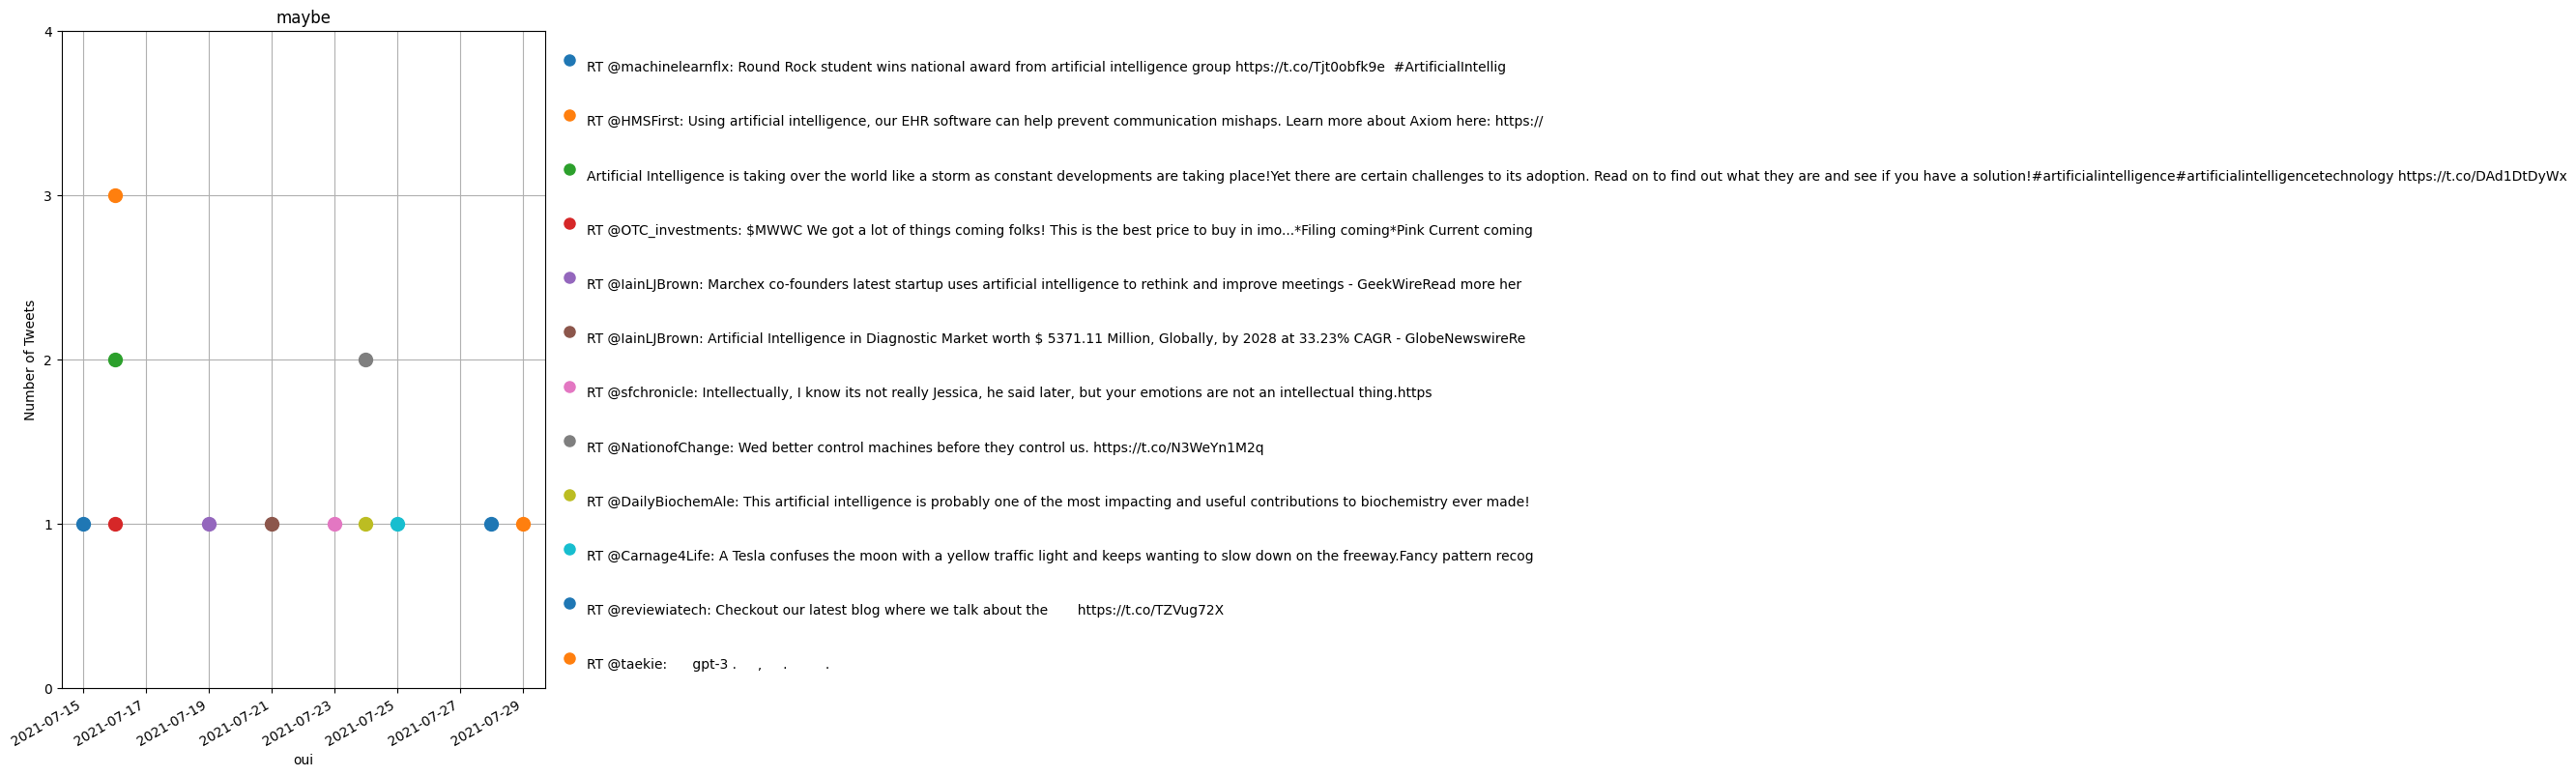

In [11]:
visualize_timeline(tweet_user, "oui", "non", "maybe", (10, 10))